In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
batch_size, num_steps = 32,35
train_iter,vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [10]:
first_batch = next(iter(train_iter))
X,Y = first_batch
print("first 5 samples of X:\n", X[:2])
print("first 5 samples of Y:\n", Y[:2])
vocab['a','b','c','d','e'],len(vocab)
print(list(vocab.token_to_idx.items())[:5])
vocab._token_freqs[:10]

first 5 samples of X:
 tensor([[12,  8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3, 10,  4, 22,  2, 12,
         12,  2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5,  3,  1, 17,  5, 12],
        [ 4,  8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,  2, 11,  1,  5,  6,
          1,  7, 14, 10,  1, 18, 12,  4,  8,  8,  2,  8,  1,  7, 14, 10,  1]])
first 5 samples of Y:
 tensor([[ 8,  5,  3,  9,  2,  1,  3,  5, 13,  2,  1,  3, 10,  4, 22,  2, 12, 12,
          2, 10,  1, 16,  7, 10,  1,  8,  7,  1,  5,  3,  1, 17,  5, 12, 12],
        [ 8,  9,  2, 11,  1,  4,  6, 11, 20,  4,  8,  8,  2, 11,  1,  5,  6,  1,
          7, 14, 10,  1, 18, 12,  4,  8,  8,  2,  8,  1,  7, 14, 10,  1, 15]])
[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4)]


[(' ', 29927),
 ('e', 17838),
 ('t', 13515),
 ('a', 11704),
 ('i', 10138),
 ('n', 9917),
 ('o', 9758),
 ('s', 8486),
 ('h', 8257),
 ('r', 7674)]

### 为什么用one-hot编码而不是索引来表示词元 ###
因为索引和索引之间是有序/有关联的，而词元和词元之间是没有关联的  
将词元映射为独热编码就可以很好地体现这种无序性

In [11]:
F.one_hot(torch.tensor([0,2]),len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们采样的数据形状是batch_size*time_steps，但rnn的计算需要按时间步来一步步计算Y，这里需要把数据先做一个转置来方便计算

In [12]:
X = torch.arange(10).reshape((2,5))
# 输入的形状是time_steps*batch_size*len(vocab)，所以需要对X先转置
F.one_hot(X.T,len(vocab)).shape

torch.Size([5, 2, 28])

In [13]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01
    
    # 隐藏层参数
    W_xh = normal((num_inputs,num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh,W_hh,b_h,W_hq,b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [14]:
# 隐状态需要与输入的形状一致，所以隐状态的形状需要设置成bathc_size*num_hiddens
# 初始化为0
def init_rnn_state(batch_size, num_hiddens, device):
    # 返回元组
    return (torch.zeros((batch_size, num_hiddens), device=device),)

### RNN和CNN在处理批量输入时的方式是不同的：  ###

对于CNN，每个输入样本在网络中是独立处理的。也就是说，一个批量的处理可以看作是多个单独样本处理的并行化。

对于RNN，由于其循环的性质，一个序列中的每个元素都依赖于前一个元素的状态。因此，虽然在每一步都处理一个批量的输入，但是这个批量中的每个序列都是按照时间步骤顺序处理的。也就是说，RNN需要处理完一个序列的所有时间步骤，才能开始处理下一个序列。

In [16]:
def rnn(inputs, state, params):
    # inputs的形状：（时间步数，批量大小，词表大小）
    W_xh, W_hh, b_h, W_hq, b_q = params
    # state是一个元组，逗号用来解包元组
    H, = state
    # outputs是一个列表，最后输出时需要打包成一个张量
    outputs = []
    # X的形状：（批量大小，词表大小）
    # 一次rnn需要把所有时间步的输入都输入进去
    for X in inputs:
        H = torch.tanh(torch.mm(X,W_xh)+torch.mm(H,W_hh)+b_h)
        Y = torch.mm(H,W_hq)+b_q
        # Y的形状：（批量大小，词表大小）
        outputs.append(Y)
    # outputs的形状：（时间步数，批量大小，词表大小），和inputs形状一致
    # 在经过0维拼接之后，输出的形状变为（时间步数*批量大小，词表大小）
    return torch.cat(outputs,dim=0),(H,)

In [44]:
class RNNModelScratch: #@save
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    # __call__()函数使得实例可以像函数一样被调用
    def __call__(self, X, state):
        # 输入的形状是time_steps*batch_size*len(vocab)
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [45]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state),new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [46]:
vocab.idx_to_token[5]

'i'

注意Y的输出形状是（10，28），也即是（2*5，28）。  
rnn()的一次时间步计算一个batch_size（2）的Y，总共time_steps（5）个的时间步，最后用torch.cat()将所有时间步的Y在0维上合并。

### 预热（warm-up） ###  
不断地将隐状态传递到下一个时间步，但是不生成任何输出

In [47]:
# 在prefix后面生成新字符
def predict_ch8(prefix, num_preds, net, vocab, device): #@save
    state = net.begin_state(batch_size=1,device=device)
    # vocab[prefix[0]]返回的是prefix的第一个字符的索引
    outputs = [vocab[prefix[0]]]
    # 获取outputs的最后一个元素
    get_input = lambda:torch.tensor([outputs[-1]],device=device).reshape(1,1)
    for y in prefix[1:]: #预热期
        # 预热期的输入就是输出的最后一个值
        _,state = net(get_input(),state)
        # 直接将输入的字符索引添加到outputs中
        outputs.append(vocab[y])
    # 开始预测
    for _ in range(num_preds):
        y, state = net(get_input(),state)
        # y是one-hot向量，用argmax找到最大概率的字符的索引
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    # 将索引转换成字符
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [48]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller cfytviekyn'

### 梯度裁剪 ###
在反向传播过程中，RNN 的 T 步计算确实会导致较长的矩阵乘法链，这可能会导致梯度消失或梯度爆炸的问题。为了解决这些问题，通常会使用梯度裁剪（Gradient Clipping）技术。具体步骤如下：

1. **计算梯度**：首先，通过反向传播计算每个参数的梯度。

2. **计算梯度范数**：计算所有参数梯度的 L2 范数（或其他范数）。L2 范数可以表示为：
   $
   \text{grad\_norm} = \sqrt{\sum_{i} \left(\frac{\partial L}{\partial \theta_i}\right)^2}
   $  
   其中 $\frac{\partial L}{\partial \theta_i}$ 是损失函数 $L$ 关于参数 $ \theta_i $ 的梯度。  

3. **设定阈值**：选择一个合适的阈值 $ \text{clip\_value} $。  

4. **裁剪梯度**：如果梯度范数超出了这个阈值，则对梯度进行缩放，使其范数等于阈值。具体操作是：  
   $
   \text{scaling\_factor} = \frac{\text{clip\_value}}{\max(\text{clip\_value}, \text{grad\_norm})}
   $  
   然后用这个缩放因子来调整每个梯度：  
   $
   \frac{\partial L}{\partial \theta_i} = \frac{\partial L}{\partial \theta_i} \times \text{scaling\_factor}
   $  
   这样做可以确保梯度的范数不会超过设定的阈值，从而避免梯度爆炸的问题。

In [49]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    # 由于p.grad是一个多维张量，除了外层的sum()，对于每个参数p的梯度都要平方求和
    norm = torch.sqrt(sum(torch.sum(p.grad**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta/norm

### 训练 ###
1. 序列数据的不同采样方式（顺序/随机）将导致隐状态初始化差异
1. 在更新参数之前裁剪梯度
1. 用困惑度来评价模型

In [55]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """ 训练网络的一个迭代周期 """
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) #训练损失之和，词元数量
    for X,Y in train_iter:
        # 如果是最一开始or使用随机采样，需要初始化隐状态
        if state is None or use_random_iter:
            state = net.begin_state(batch_size = X.shape[0], device=device)
        else:
            # 如果是顺序采样，当前样本的最后一个时间步的隐状态将会成为下一个样本的初始隐状态
            # 但如果将前一个batch的隐状态继承给后一个，梯度会在每个时间步累计
            # 为了阻止梯度累计，使用分离.detach_()阻止反向传播跨batch边界
            # .detach_()是一个原地操作，直接修改张量，将state从计算图中分离出来
            if isinstance(net,nn.Module) and not isinstance(state, tuple):
                # 当state对于nn.GRU是一个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                # 我们现在的state就是打包成了一个元组
                for s in state:
                    s.detach_()
        # Y的形状是（批量大小，时间步数），
        # 转置后y的形状是（时间步数，批量大小）
        # .reshape(-1)是将形状变为（时间步数*批量大小）
        y = Y.T.reshape(-1)
        X,y = X.to(device),y.to(device)
        # 这一步可以看出迭代使用state
        y_hat,state = net(X,state)
        # 注意y_hat的形状是（时间步数*批量大小，词表大小）,y的形状是（时间步数*批量大小）
        # 交叉熵损失函数会将每个目标值'y'作为索引，
        # 从y_hat的one-hot向量中取出对应索引的预测概率，来计算损失
        # 为了防止y为浮点类型的索引，我们需要将y变为整数（.long()）
        # .mean() 这里使用平均损失
        l = loss(y_hat,y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            # 梯度裁剪
            grad_clipping(net,1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net,1)
            # 损失已经做了一次平均，梯度也是基于平均损失计算，所以这里batch_size设为1
            updater(batch_size=1)
        # 累加batch_size个样本的损失和样本数
        metric.add(l*y.numel(), y.numel())
    # 返回平均困惑度和训练速度
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [56]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch',ylabel='perplexity',
                            legend=['train'], xlim=[10,num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(),lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    # 预测prefix向后的50个字符
    predict = lambda prefix:predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter
        )
        if (epoch+1)%10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1,ppl)
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 61676.1 词元/秒 cuda:0
time traveller for so it will be convenient to speak of himwas e
traveller with a slight accession ofcheerfulness really thi


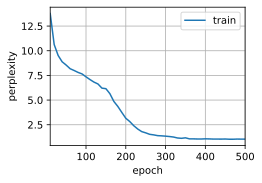

In [57]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())